# Simple Random Forest Implementation
#### (NSL KDD Dataset)

In [7]:
import time
from typing import Any

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier  # Changed to Random Forest

# Things that belong to strongly predictions, we just remove this
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']

# Define nominal and binary columns
# numeric is calculated using above 2.
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

#### Helper Functions
 Utility code common between all the models.

In [8]:
def define_numeric_column(data: pd.DataFrame) -> list[Any]:
    # Define numeric columns dynamically based on the dataframe
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]


def print_score():
    # Calculate other evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"SIMPLE RANDOM FOREST")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Decision Tree Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))


def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:  # Arbitrary threshold (e.g., 5% gap)
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:  # Arbitrary low threshold
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")


def preprocess_data(data: pd.DataFrame) -> tuple:
    data = data.copy()
    # Data cleaning
    data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
    # Define columns
    numeric = define_numeric_column(data)
    return data[nominal + numeric + binary], data['attack_category']


def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

# Model Training & Evaluation

In [9]:
# Load and preprocess data
df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # Default: 100 trees
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on both training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print_score()
check_fitting()

SIMPLE RANDOM FOREST

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      1.00      1.00     15411
         dos       1.00      1.00      1.00     10713
       probe       1.00      1.00      1.00      2816
         r2l       0.99      0.97      0.98       714
         u2r       0.93      0.74      0.82        50

    accuracy                           1.00     29704
   macro avg       0.98      0.94      0.96     29704
weighted avg       1.00      1.00      1.00     29704

Decision Tree Model Evaluation:
Training Time: 19.0980 seconds
Training Accuracy: 0.9994
Testing Accuracy: 0.9959
Precision (Weighted): 0.9959
Recall (Weighted): 0.9959
F1-Score (Weighted): 0.9959

Confusion Matrix with Class Labels:
        benign    dos  probe  r2l  u2r
benign   15373     21     11    5    1
dos         34  10678      1    0    0
probe       12      0   2804    0    0
r2l         21      0      0  691    2
u2r         12      0      0    1   

# Understandablity of the Model

In [17]:
! echo "WORK IN PROGRESS"

"WORK IN PROGRESS"


# ROC Curve

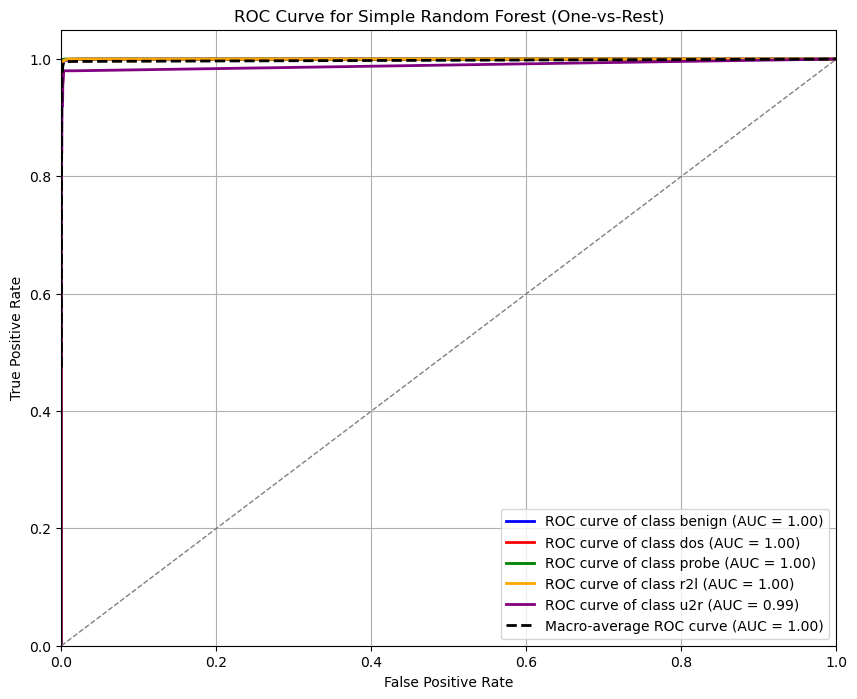

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve Visualization ---
# Get predicted probabilities for ROC
y_test_prob = rf_model.predict_proba(X_test)

# Binarize y_test for multi-class ROC (One-vs-Rest)
from sklearn.preprocessing import label_binarize
class_names = np.unique(y)
n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=class_names)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust for 5 classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["macro"], tpr["macro"], color='black', lw=2, linestyle='--',
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Simple Random Forest (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()